In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import sys
sys.path.append("/home/ubuntu/Notebooks/annsa/")

import tensorflow.contrib.eager as tfe
from sklearn import datasets, preprocessing, model_selection

import annsa as an
import tensorflow as tf
import numpy as np

/home/ubuntu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.ops.init_ops import glorot_uniform_initializer

In [3]:
tf.enable_eager_execution()

#### Define neural network

In [4]:
class simple_nn(tf.keras.Model):
    def __init__(self, model_features):
        super(simple_nn, self).__init__()
        """ Define here the layers used during the forward-pass 
            of the neural network.
        """
        l2_regularization_scale=model_features.l2_regularization_scale
        dropout_probability=model_features.dropout_probability
        nodes_layer_1=model_features.nodes_layer_1
        nodes_layer_2=model_features.nodes_layer_2      
        # define l2 regularization
        self.regularizer = tf.keras.regularizers.l2(l=l2_regularization_scale)        
        # Hidden layer.
        self.dense_layer1 = tf.layers.Dense(nodes_layer_1, 
                                            activation=tf.nn.relu,
                                            kernel_initializer=tf.truncated_normal_initializer(stddev = 1/np.sqrt(1024)),
                                            #kernel_initializer=glorot_uniform_initializer(),
                                            kernel_regularizer=self.regularizer)
        self.drop1 = tf.layers.Dropout(dropout_probability)
        self.dense_layer2 = tf.layers.Dense(nodes_layer_2,
                                            activation=tf.nn.relu,
                                            kernel_initializer=tf.truncated_normal_initializer(stddev = 1/np.sqrt(nodes_layer_1)),
                                            #kernel_initializer=glorot_uniform_initializer(),
                                            kernel_regularizer=self.regularizer)
        self.drop2 = tf.layers.Dropout(dropout_probability)
        # Output layer. No activation.
        self.output_layer = tf.layers.Dense(32, activation=None)
        
    def predict_logits(self, input_data, training=True):
        """ Runs a forward-pass through the network. Only outputs logits for loss function. 
            This is because tf.nn.softmax_cross_entropy_with_logits calculates softmax internally.   
            Note, dropout training is true here.
            Args:
                input_data: 2D tensor of shape (n_samples, n_features).   
            Returns:
                logits: unnormalized predictions.
        """
        # Reshape input data
        x=tf.reshape(input_data,[-1,1,1024])
        x=self.dense_layer1(x)
        x=self.drop1(x,training)
        x=self.dense_layer2(x)
        x=self.drop2(x,training)
        logits=self.output_layer(x)
        
        return logits
    
    def predict(self, input_data, training=False):
        """ Runs a forward-pass through the network and uses softmax output. Dropout training is off, this is 
            not used for gradient calculations in loss function.
            Args:
                input_data: 2D tensor of shape (n_samples, n_features).   
            Returns:
                logits: unnormalized predictions.
        """
        # Reshape input data
        x = tf.reshape(input_data,[-1,1,1024])
        x = self.dense_layer1(x)
        x = self.drop1(x,training)
        x = self.dense_layer2(x)
        x = self.drop2(x,training)
        x = self.output_layer(x)
        outputs = tf.nn.softmax(x)
        return outputs
    
    def loss_fn(self, input_data, target, training=True):
        """ Defines the loss function used during 
            training.         
        """
        logits = self.predict_logits(input_data, training)
        cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=logits))
        l2_weights = [self.weights[i] for i in range(len(self.weights)) if i%2==0]
        l2_loss = tf.contrib.layers.apply_regularization(self.regularizer, l2_weights)
        loss = cross_entropy_loss+l2_loss
        return loss
    
    def grads_fn(self, input_data, target):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(input_data, target) 
        return tape.gradient(loss, self.variables)
    
    def fit(self, input_data, target, optimizer, num_epochs=500, verbose=50):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs.
        """
        for i in range(num_epochs):
            grads = self.grads_fn(input_data, target)
            optimizer.apply_gradients(zip(grads, self.variables))
            if (i==0) | ((i+1)%verbose==0):
                print('Loss at epoch %d: %f' %(i+1, self.loss_fn(input_data, target, training=False).numpy()))
                
    
    def fit_batch(self, train_dataset,test_dataset, optimizer, num_epochs=50, verbose=50):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs.
        """
        all_loss_train=[]
        all_loss_test=[0]
        for i in range(num_epochs):
            for (input_data, target) in tfe.Iterator(train_dataset.shuffle(1e5).batch(512)):
                grads = self.grads_fn(input_data, target)
                optimizer.apply_gradients(zip(grads, self.variables))
                all_loss_train.append(self.loss_fn(input_data, target, training=False).numpy())
                all_loss_test.append(self.loss_fn(test_dataset[0],test_dataset[1], training=False).numpy())
            if (i==0) | ((i+1)%verbose==0):
                print('Loss at epoch %d: %3.2f %3.2f' %(i+1, np.average(all_loss_train[-10:]), np.average(all_loss_test[-10:])))
        return all_loss_train, all_loss_test

In [5]:
class model_features(object):
    
    def __init__(self,learining_rate,
                      l2_regularization_scale,
                      dropout_probability,
                      nodes_layer_1,
                      nodes_layer_2
                ):
        self.learining_rate=learining_rate
        self.l2_regularization_scale=l2_regularization_scale
        self.dropout_probability=dropout_probability
        self.nodes_layer_1=nodes_layer_1
        self.nodes_layer_2=nodes_layer_2


#### Get some data

In [6]:
training_data = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/spectrum_data_1-simplex_1E6.npy')[:-10000]
training_keys = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/key_data_1-simplex_1E6.npy')[:-10000]

training_data = an.log_normalize(training_data)
training_keys = an.normalize_data(training_keys)

X_tensor = tf.constant(training_data)
y_tensor = tf.constant(training_keys)

train_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

In [7]:
testing_data = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/spectrum_data_1-simplex_1E6.npy')[-1000:]
testing_keys = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/key_data_1-simplex_1E6.npy')[-1000:]

testing_data = an.log_normalize(testing_data)
testing_keys = an.normalize_data(testing_keys)

X_tensor = tf.constant(testing_data)
y_tensor = tf.constant(testing_keys)

test_dataset = (testing_data, testing_keys)
#test_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

#### Define an optimizer, model, and train the network

In [8]:
new_model_features = model_features(learining_rate=4.5e-3,
                                    l2_regularization_scale=1.09e-3,
                                    dropout_probability=1.0-0.96,
                                    nodes_layer_1=449,
                                    nodes_layer_2=205)

In [9]:
optimizer = tf.train.AdamOptimizer(new_model_features.learining_rate)
model = simple_nn(new_model_features)
all_loss_train, all_loss_test = model.fit_batch(train_dataset,test_dataset, optimizer, num_epochs=10, verbose=1)

Loss at epoch 1: 1.67 1.67
Loss at epoch 2: 1.44 1.46
Loss at epoch 3: 1.39 1.41
Loss at epoch 4: 1.39 1.41
Loss at epoch 5: 1.37 1.39
Loss at epoch 6: 1.34 1.36
Loss at epoch 7: 1.33 1.35
Loss at epoch 8: 1.33 1.34
Loss at epoch 9: 1.34 1.36
Loss at epoch 10: 1.33 1.34


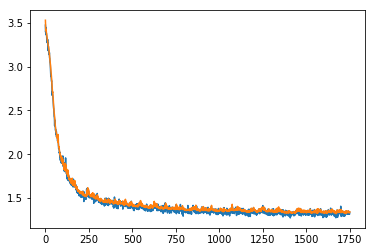

In [10]:
plt.plot(all_loss_train[10:])
plt.plot(all_loss_test[10:])
#plt.xlim([0,500])
#plt.ylim([2.9,3.0])

#### Check outputs

In [12]:
index = 100

logits_test = model.predict(training_data[index])

an.results2(training_keys[index],5)
print '\n'
an.results2(logits_test.numpy()[0][0],5)

('Ba133', 0.8499593661113368)
('Back_Th', 0.11905729378301504)
('Back_K', 0.01574563185696871)
('Back_U', 0.015237708248679399)
('U235', 0.0)


('Ba133', 0.8939623790696212)
('Back_Th', 0.03925428874613645)
('Back_U', 0.03395918333178101)
('Back_K', 0.017143611190704938)
('I131', 0.010330148635405682)
